# Humpback Whale Identification - CNN with Keras

In [1]:
import gc
import os
import time

In [2]:
# Mutual exclusion trick :O (with a lock file) #Mutex #Beurk #DeepLearning
while os.path.isfile("lock"):
    time.sleep(30)

In [3]:
!touch lock

In [4]:
import numpy as np
import pandas as pd
import progressbar

import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [5]:
train_df = pd.read_csv("../../input/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [6]:
def prepareImages(data, m, dataset):
    #print("Preparing images")
    #print(m)
    X_train = np.zeros((m, 64, 64, 3))
    count = 0
    
    for fig in progressbar.progressbar(data['Image']):
        # load images into images of size 128x128x3
        img = image.load_img("../../input/"+dataset+"/"+fig, target_size=(64, 64, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
    
    return X_train

In [7]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    #print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    #print(onehot_encoded)

    y = onehot_encoded
    #print(y.shape)
    return y, label_encoder

In [8]:
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255

100% (25361 of 25361) |##################| Elapsed Time: 0:02:52 Time:  0:02:52


In [ ]:
y, label_encoder = prepare_labels(train_df['Id'])

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [ ]:
y.shape

(25361, 5005)

# Change model starting from here

## Train

In [ ]:
model = Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (64, 64, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(y.shape[1], activation='softmax', name='sm'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 58, 58, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 58, 58, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 58, 58, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 29, 29, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 27, 27, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 27, 27, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 9, 9, 64)          0         
__________

In [ ]:
history = model.fit(X, y, epochs=100, batch_size=100, verbose=1)
gc.collect()

Epoch 1/100
25361/25361 [==============================] - 13s 517us/step - loss: 6.1765 - acc: 0.3797
Epoch 2/100
25361/25361 [==============================] - 12s 462us/step - loss: 5.9119 - acc: 0.3811
Epoch 3/100
25361/25361 [==============================] - 12s 462us/step - loss: 5.7941 - acc: 0.3811
Epoch 4/100
25361/25361 [==============================] - 12s 462us/step - loss: 5.7376 - acc: 0.3811
Epoch 5/100
25361/25361 [==============================] - 12s 463us/step - loss: 5.7067 - acc: 0.3811
Epoch 6/100
25361/25361 [==============================] - 12s 463us/step - loss: 5.6902 - acc: 0.3811
Epoch 7/100
25361/25361 [==============================] - 12s 463us/step - loss: 5.6738 - acc: 0.3811
Epoch 8/100
25361/25361 [==============================] - 12s 463us/step - loss: 5.6467 - acc: 0.3811
Epoch 9/100
25361/25361 [==============================] - 12s 463us/step - loss: 5.6282 - acc: 0.3811
Epoch 10/100
25361/25361 [==============================] - 12s 463us/ste

0

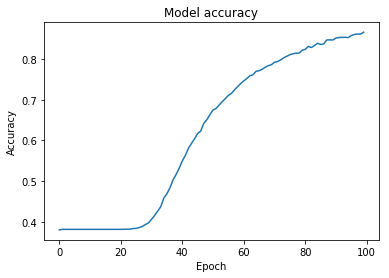

In [ ]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Test

In [ ]:
test = os.listdir("../../input/test/")
print(len(test))

7960


In [ ]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [ ]:
X = prepareImages(test_df, test_df.shape[0], "test")
X /= 255

100% (7960 of 7960) |####################| Elapsed Time: 0:00:56 Time:  0:00:56


In [ ]:
predictions = model.predict(np.array(X), verbose=1)

7960/7960 [==============================] - 2s 204us/step


In [ ]:
for i, pred in enumerate(predictions):
    test_df.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))

In [ ]:
test_df.head(10)
test_df.to_csv('keras-cnn-starter.csv', index=False) #> Score = 0.286

In [ ]:
#!kaggle competitions submit -c humpback-whale-identification -f "keras-cnn-starter.csv" -m "Keras CNN starter (64x64)"

100%|█████████████████████████████████████████| 498k/498k [00:04<00:00, 103kB/s]
Successfully submitted to Humpback Whale Identification

In [ ]:
!rm lock

In [ ]:
%%javascript
// From https://github.com/jupyter/notebook/issues/1880
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>